<a href="https://colab.research.google.com/github/TomJZ/DeepLearningForDynamics-Intuition/blob/main/torchdiffeq_lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import torch
!pip install torchdiffeq
import torchdiffeq

import os
import sys
import argparse
import time
import numpy as np
from IPython.display import clear_output


import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

# Setting things up

In [ ]:
# arguments
parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--system', type=str, choices=['fixed_point', 'lorenz'], default='lorenz')  # change this for different systems
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
args, unknown = parser.parse_known_args()

In [ ]:
if args.adjoint:  
    from torchdiffeq import odeint_adjoint as odeint # adjoint method
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# Visualization

In [ ]:
def visualize_3d(obs=None, noiseless_traj=None,times=None, trajs=None, save=None, title=''):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if title is not None:
      ax.set_title('Trajectory\n'+title)

    if noiseless_traj is not None:
      z = np.array([o.detach().numpy() for o in noiseless_traj])
      z = np.reshape(z, [-1,3])
      for i in range(len(z)):
        ax.plot(z[i:i+10, 0], z[i:i+10, 1], z[i:i+10, 2], color=plt.cm.jet(i/len(z)/1.6))

    if obs is not None:
      z = np.array([o.detach().numpy() for o in obs])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)

    if trajs is not None:
      z = np.array([o.detach().numpy() for o in trajs])
      z = np.reshape(z, [-1,3])
      for i in range(len(z)):
        ax.plot(z[i:i+10, 0], z[i:i+10, 1], z[i:i+10, 2], color='r', alpha=0.3)

    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.1)
    plt.show()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
        pass

In [ ]:
def visualize_2d(true_y, pred_y, odefunc, itr):
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)

    #ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.set_ylim(-2, 2)
    # ax_traj.legend()

    #ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(-2, 2)
    ax_phase.set_ylim(-2, 2)

    #ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('x')
    ax_vecfield.set_ylabel('y')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)

    fig.tight_layout()
    # plt.savefig('png/{:03d}'.format(itr))
    plt.show()

# Fixed Point
includes system dynamics and true trajectory generation

In [ ]:
# fixed point
true_y0 = torch.tensor([[2., 0.]]).to(device)  # initial condition
t = torch.linspace(0., 25., args.data_size).to(device)  # t is from 0 to 25 for 1000 data points
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)  # true system dynamics of fixed point

# system dynamics
class FixedPoint(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)  # true system derivatives

# generating training data
with torch.no_grad():
    true_fixed_point = odeint(FixedPoint(), true_y0, t, method='dopri5')

# Lorenz System

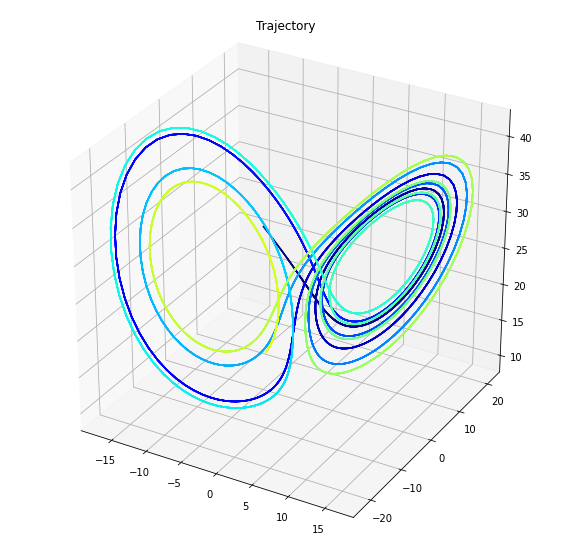

In [ ]:
# lorenz system dynamics
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[-8., 7., 27.]]).to(device)  # initial condition
t = torch.linspace(0., 10., args.data_size).to(device)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    true_lorenz = odeint(Lorenz(), true_y0, t, method='rk4')

visualize_3d(noiseless_traj=true_lorenz)

# Neural Network Models

In [ ]:
# A 2D system for fixed point
class FixedPointTrain(nn.Module):
    def __init__(self):
        super(FixedPointTrain, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

# A 3D system for Lorenz system
class LorenzTrain(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(LorenzTrain, self).__init__()
        self.lin = nn.Linear(3, 256)
        self.lin3 = nn.Linear(256, 3)
        self.relu = nn.ReLU()

    def forward(self, t, x):
        x = self.relu(self.lin(x))
        x = self.lin3(x)
        return x

# Training

In [ ]:
# Stochastic Gradient Descent
def get_batch(traj):
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = traj[s]  # (M, D)
    batch_t = t[:args.batch_time]  # (T)
    batch_y = torch.stack([traj[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Gradient Descent (do not randomly pick samples from true trajectory)
def get_regular_batch(traj):
    s = np.arange(len(traj)-1)
    batch_y0 = traj[s]  # (M, D)
    batch_t = t[:2]  # (T)
    batch_y = torch.stack([traj[s + i] for i in range(2)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

## Training Loop

In [ ]:
ii = 0
if args.system == "lorenz":
    train_data = true_lorenz
    func = LorenzTrain().to(device)  # initializing Neural ODE
    visualizer = visualize_3d
elif args.system == "fixed_point":
    train_data = true_fixed_point
    func = FixedPointTrain().to(device)  # initializing Neural ODE
    visualizer = visualize_2d

optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, args.niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_regular_batch(train_data)  # getting trajectory batch
    pred_y = odeint(func, batch_y0, batch_t, method='rk4').to(device)  # prediction using batch initial condition and batch time stamps
    loss = F.mse_loss(pred_y, batch_y)
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args.test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, train_data[0], t)
            loss = F.mse_loss(pred_y, train_data)
            
            if args.system == "lorenz":
                visualize_3d(obs=train_data, noiseless_traj=pred_y)
            elif args.system == "fixed_point":
                visualize_2d(train_data, pred_y, func, ii)

            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            clear_output(wait=True)
            ii += 1

    end = time.time()